In [1]:
data.describe()


NameError: ignored

In [13]:
data.shape

(24277, 14)

Epoch 1/50
36/36 [==============================] - 2s 14ms/step - loss: 0.8342 - val_loss: 0.7402
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.5614 - val_loss: 0.4335
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2381 - val_loss: 0.0788
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0398 - val_loss: 0.0334
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.0293
Epoch 6/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0233 - val_loss: 0.0247
Epoch 7/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0198 - val_loss: 0.0218
Epoch 8/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0172 - val_loss: 0.0191
Epoch 9/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0149 - val_loss: 0.0169
Epoch 10/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0131 - val_loss: 0.0149
Epoch 11/50
36/36 

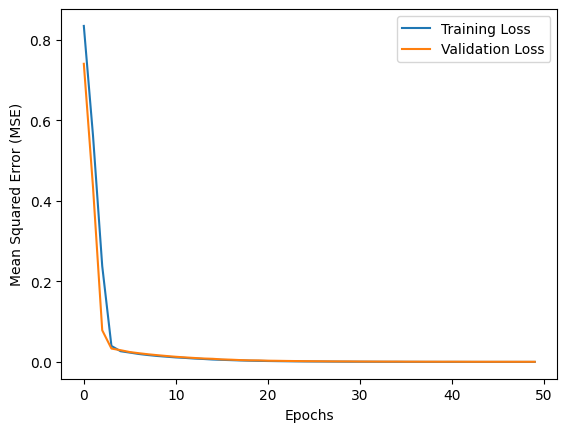

<ipython-input-34-589a9bb1e519>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


95/95 [==============================] - 0s 1ms/step


ValueError: ignored

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 1: Load the dataset
data = pd.read_csv('/content/DR_LaneChange_ET0_obs.csv')  # Replace 'vehicle_tracks.csv' with your dataset filename

# Step 2: Identify Ego Agent
ego_agent_id = data[data['interesting_agent'] == 1]['track_id'].iloc[0]

# Step 3: Trajectory Prediction with LSTM
def preprocess_data(df):
    # Preprocess the data by scaling x, y, vx, and vy features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[['x', 'y', 'vx', 'vy']])
    df[['x', 'y', 'vx', 'vy']] = scaled_data
    return df


def prepare_input_sequences(data, sequence_length=5):
    input_sequences = []
    output_sequences = []

    unique_track_ids = np.unique(data['track_id'].values)

    for track_id in unique_track_ids:
        track_data = data[data['track_id'] == track_id].copy()
        track_data = track_data.sort_values(by=['frame_id', 'timestamp_ms'])

        for i in range(len(track_data) - sequence_length + 1):
            input_seq = track_data.iloc[i:i + sequence_length, 5:9].values.astype(np.float32)  # Columns: x, y, vx, vy
            output_seq = track_data.iloc[i + sequence_length - 1, 5:9].values.astype(np.float32)  # Columns: x, y, vx, vy
            input_sequences.append(input_seq)
            output_sequences.append(output_seq)

    # Reshape the input sequences to have the shape (None, 5, 4)
    input_sequences = np.array(input_sequences)
    input_sequences = input_sequences.reshape(input_sequences.shape[0], sequence_length, -1)

    return input_sequences, np.array(output_sequences)


def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dense(2))  # 2 output units for predicting 'x' and 'y'
    return model

def train_lstm_model(df, ego_agent_id, sequence_length=5, epochs=50, batch_size=32):
    # Filter data for the specified ego_agent_id
    ego_agent_data = df[df['track_id'] == ego_agent_id].copy()

    # Scale the 'x', 'y', 'vx', and 'vy' columns
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(ego_agent_data[['x', 'y', 'vx', 'vy']])
    ego_agent_data[['x', 'y', 'vx', 'vy']] = scaled_data

    # Prepare input and output sequences for the LSTM model
    input_sequence, output_sequence = prepare_input_sequences(ego_agent_data, sequence_length)

    # Split the data into training and validation sets
    train_size = int(0.8 * len(input_sequence))
    input_sequence_train, input_sequence_val = input_sequence[:train_size], input_sequence[train_size:]
    output_sequence_train, output_sequence_val = output_sequence[:train_size], output_sequence[train_size:]

    # Reshape input sequences for LSTM (number of samples, sequence length, number of features)
    input_shape = (input_sequence_train.shape[1], input_sequence_train.shape[2])
    input_sequence_train = input_sequence_train.reshape(input_sequence_train.shape[0], sequence_length, input_sequence_train.shape[2])
    input_sequence_val = input_sequence_val.reshape(input_sequence_val.shape[0], sequence_length, input_sequence_val.shape[2])

    # Create and train the LSTM model
    ego_agent_model = Sequential()
    ego_agent_model.add(LSTM(64, input_shape=input_shape))
    ego_agent_model.add(Dense(4))  # Output layer with 4 units (x, y, vx, vy)

    ego_agent_model.compile(loss='mean_squared_error', optimizer='adam')
    training_history = ego_agent_model.fit(input_sequence_train, output_sequence_train,
                                           epochs=epochs, batch_size=batch_size,
                                           validation_data=(input_sequence_val, output_sequence_val))

    return ego_agent_model, training_history

safety_distance = 2.0  # Adjust this value based on your scenario

# Step 4: Target Agent Selection (same as before)
target_agents = data[data['track_to_predict'] == 1]['track_id'].unique()

# Step 5: Collision Detection
def collision_detection(ego_agent_x, ego_agent_y, target_agent_x, target_agent_y, ego_length, target_length, safety_distance):
    # Calculate the distance between the ego agent and the target agent at each timestep
    distances = np.sqrt((ego_agent_x - target_agent_x) ** 2 + (ego_agent_y - target_agent_y) ** 2)

    # Calculate the sum of the ego and target agent lengths to include safety distance
    sum_lengths = ego_length + target_length + safety_distance

    # Check if the minimum distance threshold is breached at any timestep
    if np.any(distances < sum_lengths):
        return True
    else:
        return False

# Step 6: Avoidance Maneuvers
def avoidance_maneuvers(ego_agent_x, ego_agent_y, target_agent_x, target_agent_y, target_agent_vx, target_agent_vy):
    # Check if collision is detected
    if collision_detection(ego_agent_x, ego_agent_y, target_agent_x, target_agent_y, ego_length, target_length, safety_distance):
        # Implement avoidance maneuvers based on the relative positions and velocities of the agents
        # For example, adjust speed, change lane, or direction to avoid collisions.
        # This is a simple example where the ego agent slows down to avoid a target agent.
        # You can implement more sophisticated logic based on your specific scenario and requirements.

        # Calculate the relative position and velocity of the ego and target agents
        relative_x = target_agent_x - ego_agent_x
        relative_y = target_agent_y - ego_agent_y
        relative_speed = np.sqrt(relative_x ** 2 + relative_y ** 2)

        # Slowing down the ego agent to half of its original speed
        new_ego_vx = ego_agent_x[0] + 0.5 * (ego_agent_x[1] - ego_agent_x[0])
        new_ego_vy = ego_agent_y[0] + 0.5 * (ego_agent_y[1] - ego_agent_y[0])

        # Update the ego agent's velocity to avoid collision
        ego_agent_x[1] = new_ego_vx
        ego_agent_y[1] = new_ego_vy

    return ego_agent_x, ego_agent_y

# Step 8: Evaluation and Visualization
def plot_trajectory(ego_agent_x, ego_agent_y, predicted_x, predicted_y):
    plt.figure(figsize=(8, 6))
    plt.plot(ego_agent_x, ego_agent_y, label='Ground Truth Trajectory', color='blue')
    plt.plot(predicted_x, predicted_y, label='Predicted Trajectory', color='orange')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.show()

def calculate_mse(predictions, ground_truth):
    return np.mean((predictions - ground_truth) ** 2)

# Set the sequence_length
sequence_length = 5

# Example usage:
ego_agent_model, training_history = train_lstm_model(data, ego_agent_id)

# Plot training and validation loss curves
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

for target_agent_id in target_agents:
    target_agent_data = data[data['track_id'] == target_agent_id]
    target_agent_data = preprocess_data(target_agent_data)

    # Prepare input sequences for LSTM (reshaping to the correct shape)
    input_sequence_target, _ = prepare_input_sequences(target_agent_data, sequence_length)

    # Predict future trajectory for the target agent
    predicted_sequence_target = ego_agent_model.predict(input_sequence_target)

    # Extract x and y predictions
    predicted_x_target = predicted_sequence_target[:, 0]
    predicted_y_target = predicted_sequence_target[:, 1]

    # Get the last known position of the target agent
    target_agent_last_x = target_agent_data['x'].iloc[-1]
    target_agent_last_y = target_agent_data['y'].iloc[-1]

    ego_agent_x = target_agent_data['x'].values[-2:]  # Last known position and predicted position
    ego_agent_y = target_agent_data['y'].values[-2:]  # Last known position and predicted position

    ego_length = target_agent_data['length'].values[0]
    target_length = target_agent_data['length'].values[0]

    # Perform collision detection and avoidance maneuvers
    if collision_detection(ego_agent_x, ego_agent_y, predicted_x_target, predicted_y_target, ego_length, target_length, safety_distance):
        ego_agent_x, ego_agent_y = avoidance_maneuvers(ego_agent_x, ego_agent_y, target_agent_last_x, target_agent_last_y)

    # Plot the trajectory prediction
    plot_trajectory(target_agent_data['x'], target_agent_data['y'], predicted_x_target, predicted_y_target)

    # Calculate and print the Mean Squared Error for the target agent's trajectory prediction
    mse_target = calculate_mse(predicted_sequence_target, target_agent_data[['x', 'y']])
    print(f'Target Agent ID: {target_agent_id}, Mean Squared Error (MSE): {mse_target}')


Epoch 1/50
36/36 [==============================] - 2s 15ms/step - loss: 0.8581 - val_loss: 0.7531
Epoch 2/50
36/36 [==============================] - 0s 5ms/step - loss: 0.5849 - val_loss: 0.4521
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2618 - val_loss: 0.0879
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0467 - val_loss: 0.0314
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0251 - val_loss: 0.0245
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0205 - val_loss: 0.0206
Epoch 7/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0175 - val_loss: 0.0191
Epoch 8/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0153 - val_loss: 0.0159
Epoch 9/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0147
Epoch 10/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0132
Epoch 11/50
36/36 

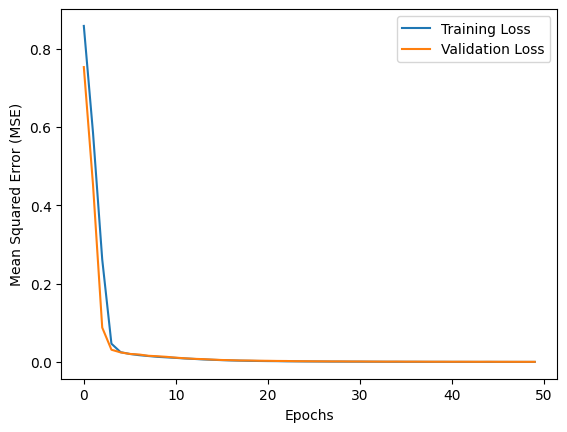

<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


1/1 [==============================] - 0s 289ms/step
Collision detected! Applying avoidance maneuvers.


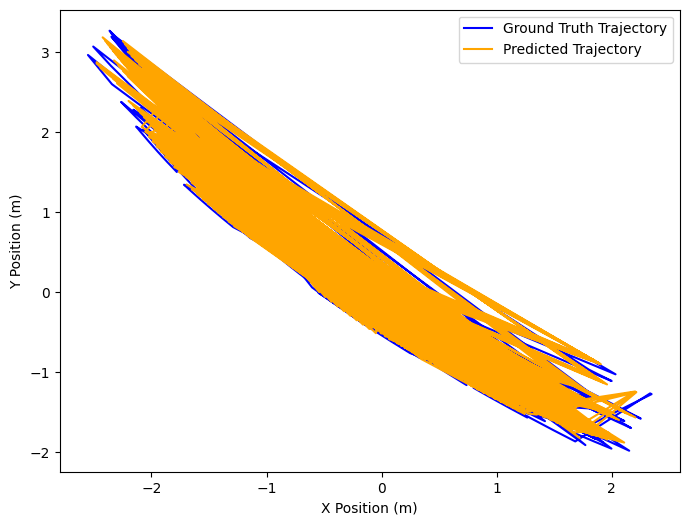

Target Agent ID: 5, Mean Squared Error (MSE): 4.000893537598645
1/1 [==============================] - 0s 23ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


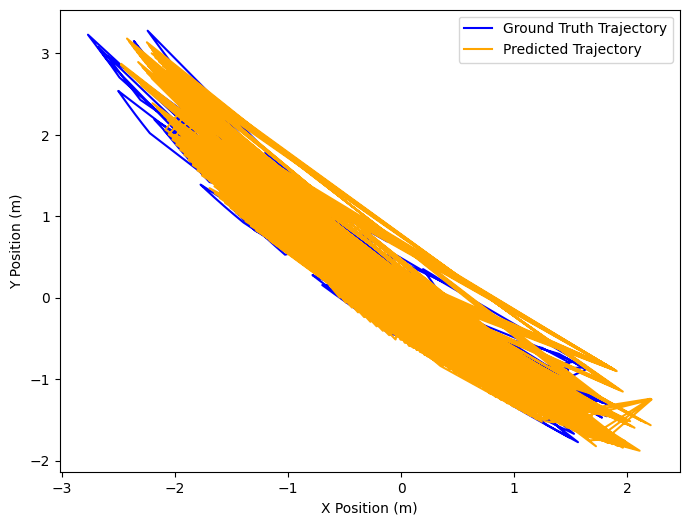

Target Agent ID: 6, Mean Squared Error (MSE): 3.737031312726258
1/1 [==============================] - 0s 15ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


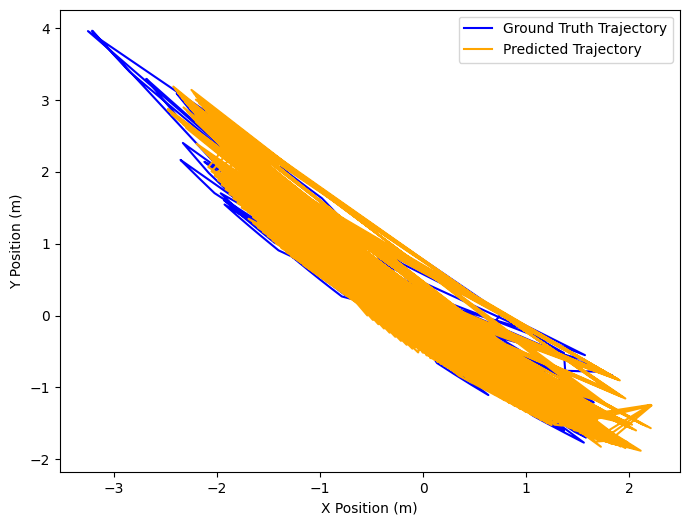

Target Agent ID: 7, Mean Squared Error (MSE): 4.034484117592989
1/1 [==============================] - 0s 16ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


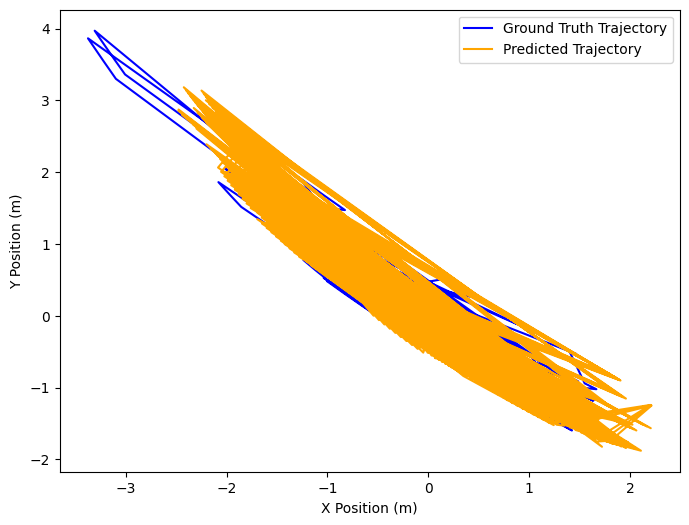

Target Agent ID: 9, Mean Squared Error (MSE): 3.8946349280348342
1/1 [==============================] - 0s 16ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


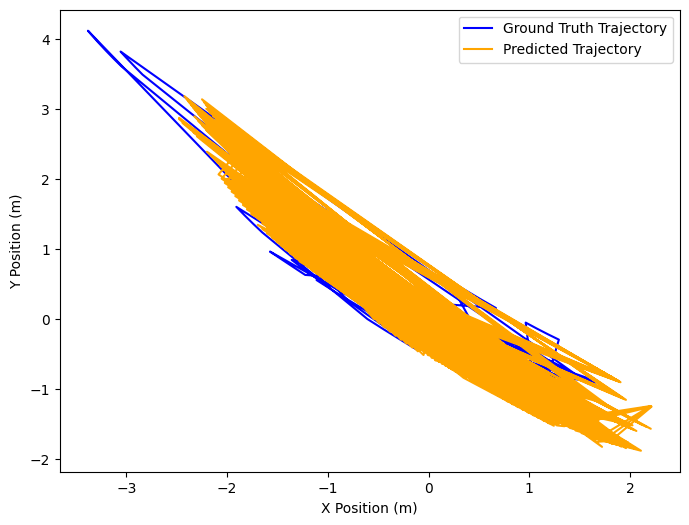

Target Agent ID: 10, Mean Squared Error (MSE): 3.9431576105500037
1/1 [==============================] - 0s 15ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


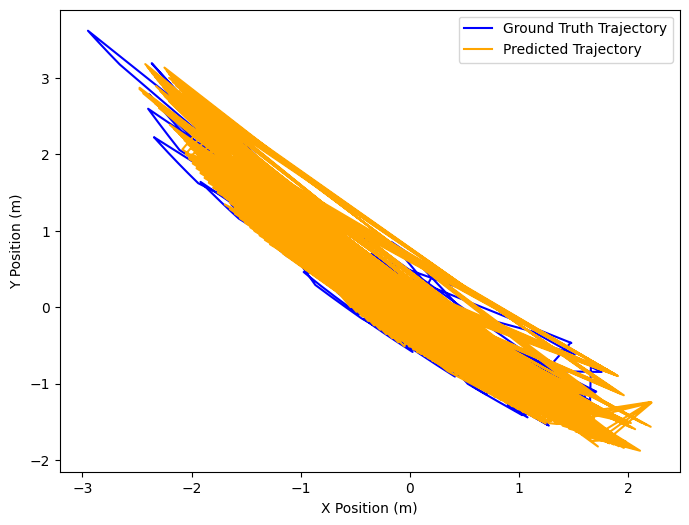

Target Agent ID: 8, Mean Squared Error (MSE): 3.876397491940945
1/1 [==============================] - 0s 16ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


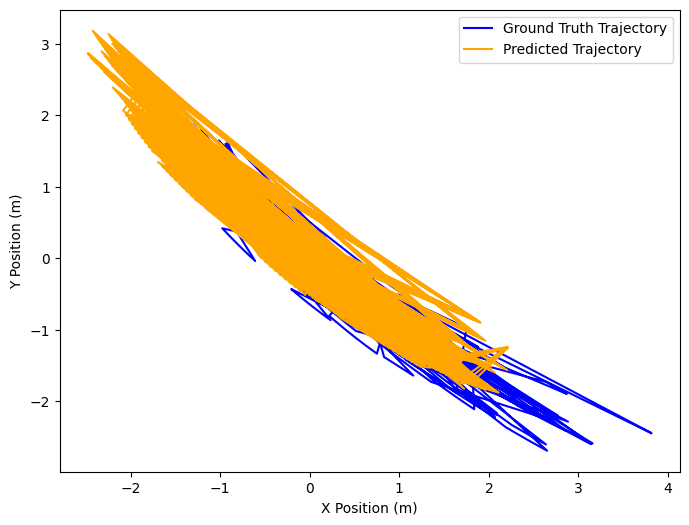

Target Agent ID: 2, Mean Squared Error (MSE): 3.966658616793722
1/1 [==============================] - 0s 15ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


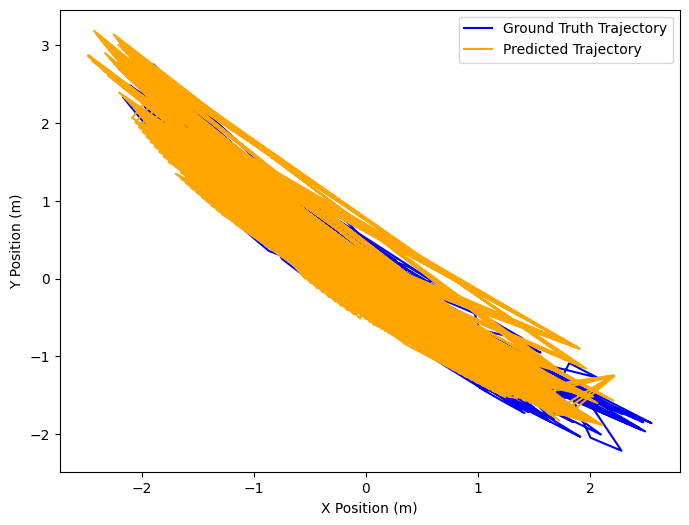

Target Agent ID: 4, Mean Squared Error (MSE): 3.9458469169736485
1/1 [==============================] - 0s 15ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


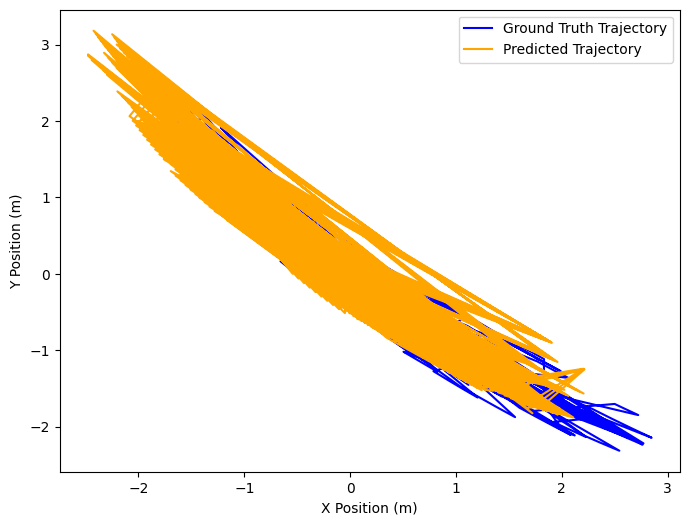

Target Agent ID: 3, Mean Squared Error (MSE): 3.9724768758002544
1/1 [==============================] - 0s 14ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


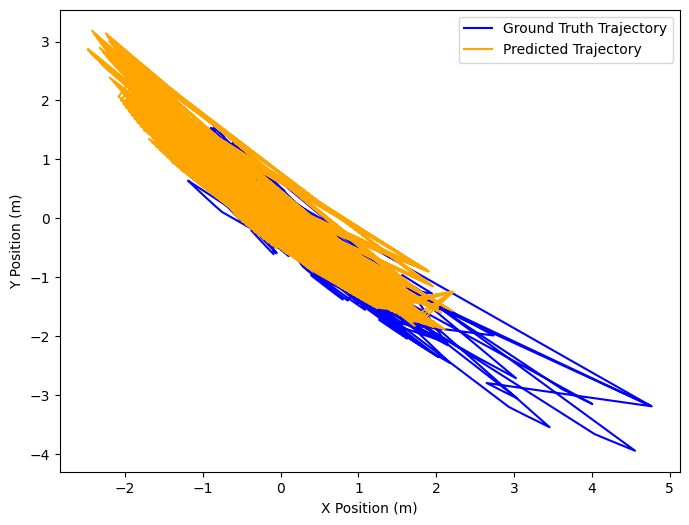

Target Agent ID: 1, Mean Squared Error (MSE): 3.8612842144131205
1/1 [==============================] - 0s 16ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


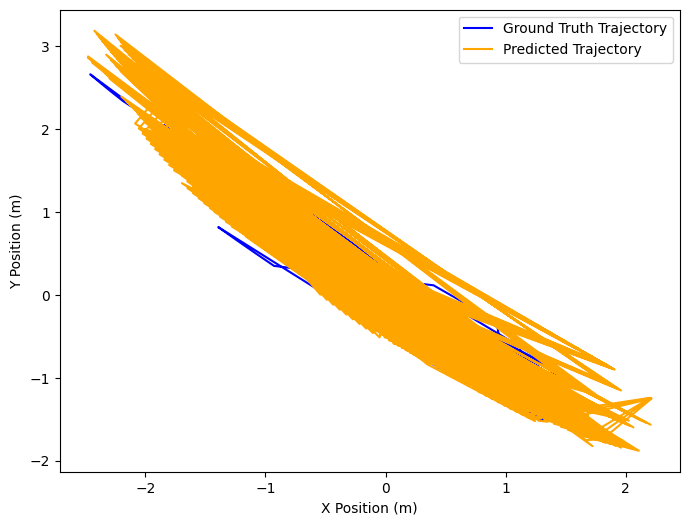

Target Agent ID: 12, Mean Squared Error (MSE): 3.887420905584821
1/1 [==============================] - 0s 16ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


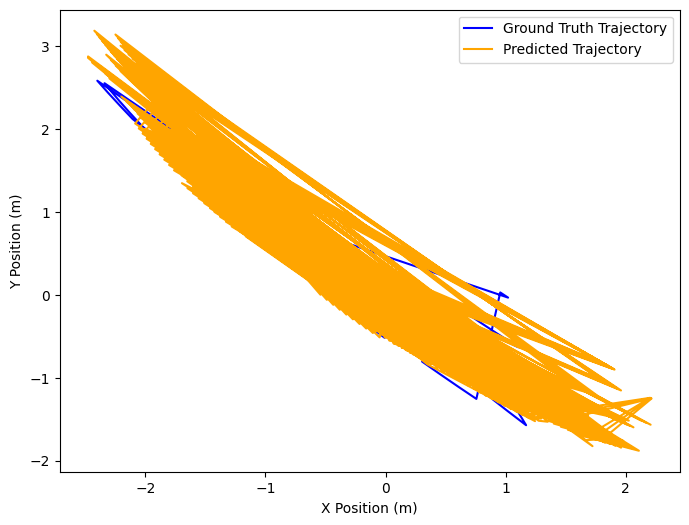

Target Agent ID: 13, Mean Squared Error (MSE): 4.236916840006974
1/1 [==============================] - 0s 64ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


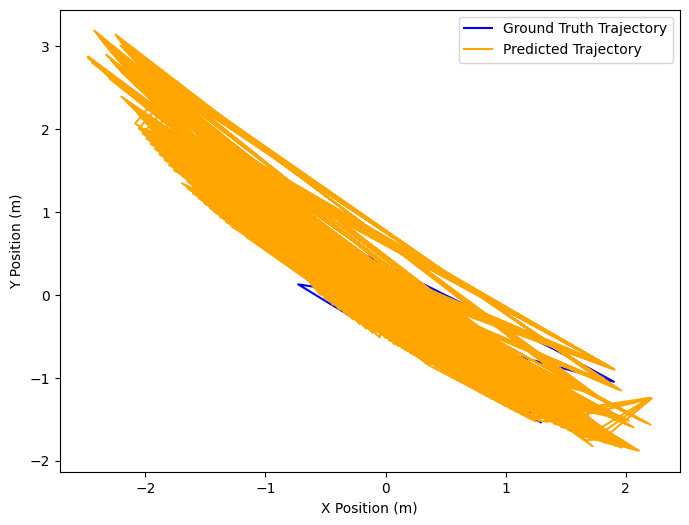

Target Agent ID: 14, Mean Squared Error (MSE): 3.3140913261104963
1/1 [==============================] - 0s 62ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


Collision detected! Applying avoidance maneuvers.


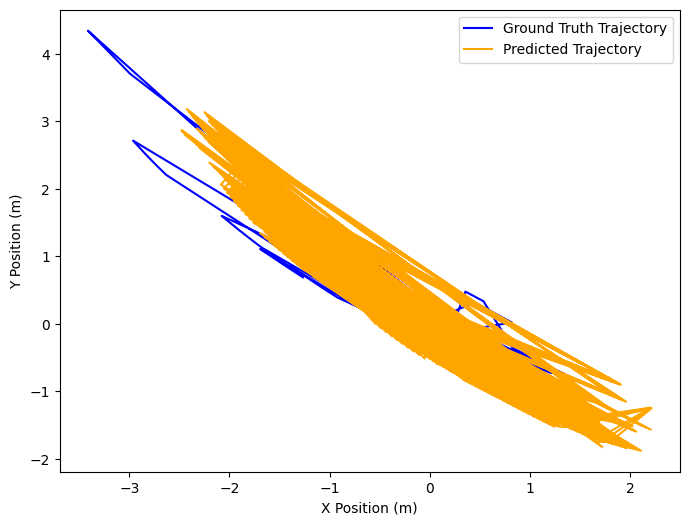

Target Agent ID: 11, Mean Squared Error (MSE): 3.9795804112729383
1/1 [==============================] - 0s 20ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


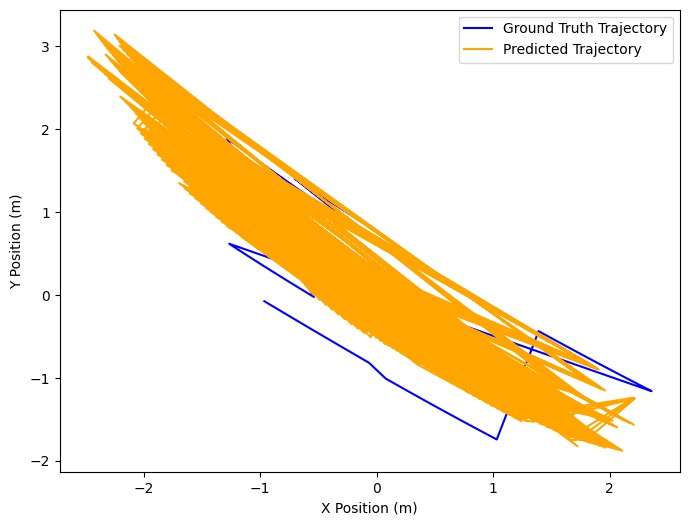

Target Agent ID: 15, Mean Squared Error (MSE): 3.741243056077908
1/1 [==============================] - 0s 27ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


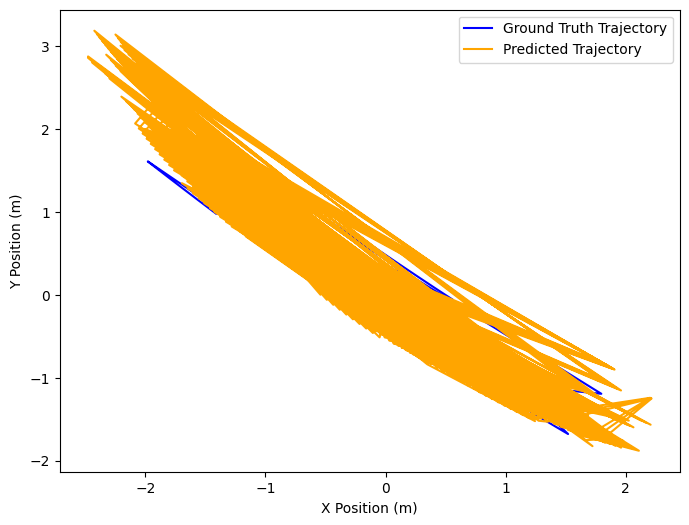

Target Agent ID: 16, Mean Squared Error (MSE): 3.103766369466792
1/1 [==============================] - 0s 20ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


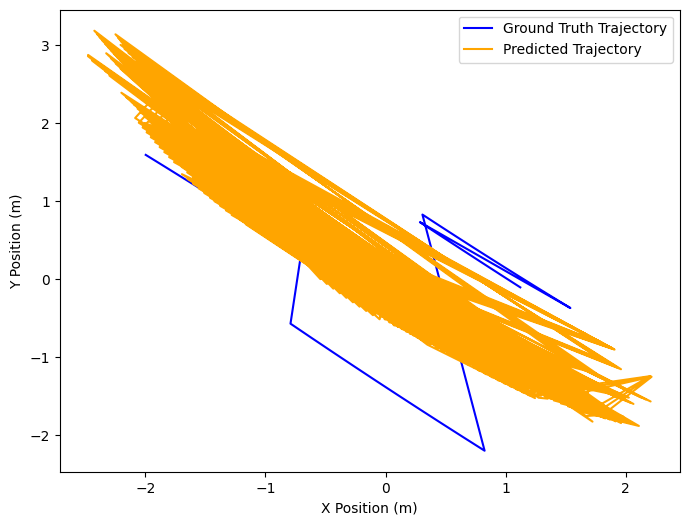

Target Agent ID: 17, Mean Squared Error (MSE): 5.163907826290059
1/1 [==============================] - 0s 27ms/step
Collision detected! Applying avoidance maneuvers.


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


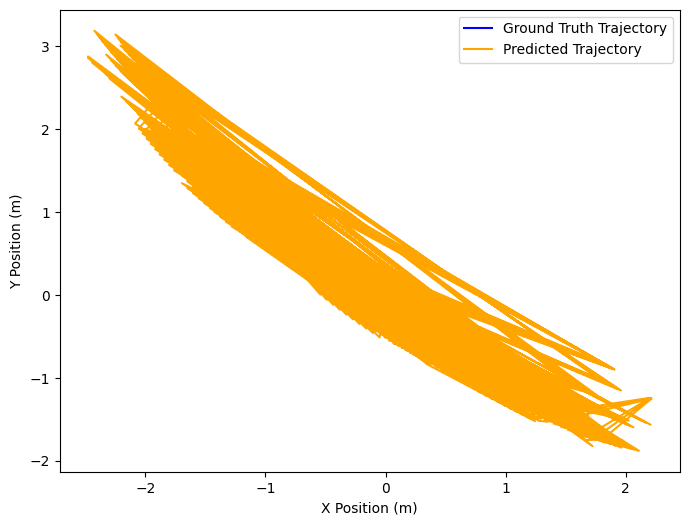

Target Agent ID: 18, Mean Squared Error (MSE): 5.32731067269781


In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 1: Load the dataset
data = pd.read_csv('/content/DR_LaneChange_ET0_obs.csv')  # Replace 'vehicle_tracks.csv' with your dataset filename

# Step 2: Identify Ego Agent
ego_agent_id = data[data['interesting_agent'] == 1]['track_id'].iloc[0]

# Step 3: Trajectory Prediction with LSTM
def preprocess_data(df):
    # Preprocess the data by scaling x, y, vx, and vy features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[['x', 'y', 'vx', 'vy']])
    df[['x', 'y', 'vx', 'vy']] = scaled_data
    return df


def prepare_input_sequences(data, sequence_length=5):
    input_sequences = []
    output_sequences = []

    unique_track_ids = np.unique(data['track_id'].values)

    for track_id in unique_track_ids:
        track_data = data[data['track_id'] == track_id].copy()
        track_data = track_data.sort_values(by=['frame_id', 'timestamp_ms'])

        for i in range(len(track_data) - sequence_length + 1):
            input_seq = track_data.iloc[i:i + sequence_length, 5:9].values.astype(np.float32)  # Columns: x, y, vx, vy
            output_seq = track_data.iloc[i + sequence_length - 1, 5:9].values.astype(np.float32)  # Columns: x, y, vx, vy
            input_sequences.append(input_seq)
            output_sequences.append(output_seq)

    # Reshape the input sequences to have the shape (None, 5, 4)
    input_sequences = np.array(input_sequences)
    input_sequences = input_sequences.reshape(input_sequences.shape[0], sequence_length, -1)

    return input_sequences, np.array(output_sequences)


def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dense(2))  # 2 output units for predicting 'x' and 'y'
    return model

def train_lstm_model(df, ego_agent_id, sequence_length=5, epochs=50, batch_size=32):
    # Filter data for the specified ego_agent_id
    ego_agent_data = df[df['track_id'] == ego_agent_id].copy()

    # Scale the 'x', 'y', 'vx', and 'vy' columns
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(ego_agent_data[['x', 'y', 'vx', 'vy']])
    ego_agent_data[['x', 'y', 'vx', 'vy']] = scaled_data

    # Prepare input and output sequences for the LSTM model
    input_sequence, output_sequence = prepare_input_sequences(ego_agent_data, sequence_length)

    # Split the data into training and validation sets
    train_size = int(0.8 * len(input_sequence))
    input_sequence_train, input_sequence_val = input_sequence[:train_size], input_sequence[train_size:]
    output_sequence_train, output_sequence_val = output_sequence[:train_size], output_sequence[train_size:]

    # Reshape input sequences for LSTM (number of samples, sequence length, number of features)
    input_shape = (input_sequence_train.shape[1], input_sequence_train.shape[2])
    input_sequence_train = input_sequence_train.reshape(input_sequence_train.shape[0], sequence_length, input_sequence_train.shape[2])
    input_sequence_val = input_sequence_val.reshape(input_sequence_val.shape[0], sequence_length, input_sequence_val.shape[2])

    # Create and train the LSTM model
    ego_agent_model = Sequential()
    ego_agent_model.add(LSTM(64, input_shape=input_shape))
    ego_agent_model.add(Dense(4))  # Output layer with 4 units (x, y, vx, vy)

    ego_agent_model.compile(loss='mean_squared_error', optimizer='adam')
    training_history = ego_agent_model.fit(input_sequence_train, output_sequence_train,
                                           epochs=epochs, batch_size=batch_size,
                                           validation_data=(input_sequence_val, output_sequence_val))

    return ego_agent_model, training_history

safety_distance = 2.0  # Adjust this value based on your scenario

# Step 4: Target Agent Selection (same as before)
target_agents = data[data['track_to_predict'] == 1]['track_id'].unique()

# Step 5: Collision Detection
def collision_detection(ego_agent_x, ego_agent_y, target_agent_x, target_agent_y, ego_length, target_length, safety_distance):
    # Calculate the distance between the ego agent and the target agent at each timestep
    distances = np.sqrt((ego_agent_x - target_agent_x) ** 2 + (ego_agent_y - target_agent_y) ** 2)

    # Calculate the sum of the ego and target agent lengths to include safety distance
    sum_lengths = ego_length + target_length + safety_distance

    # Check if the minimum distance threshold is breached at any timestep
    if np.any(distances < sum_lengths):
        return True
    else:
        return False

# Step 6: Avoidance Maneuvers
def avoidance_maneuvers(ego_agent_x, ego_agent_y, target_agent_x, target_agent_y, ego_length, target_length):
    # Check if collision is detected
    if collision_detection(ego_agent_x, ego_agent_y, target_agent_x, target_agent_y, ego_length, target_length, safety_distance):
        # Implement avoidance maneuvers based on the relative positions of the agents
        # For example, adjust speed, change lane, or direction to avoid collisions.
        # This is a simple example where the ego agent slows down to avoid a target agent.
        # You can implement more sophisticated logic based on your specific scenario and requirements.

        # Calculate the relative position of the ego and target agents
        relative_x = target_agent_x - ego_agent_x
        relative_y = target_agent_y - ego_agent_y

        # Slowing down the ego agent to half of its original speed
        new_ego_vx = ego_agent_x[0] + 0.5 * (ego_agent_x[1] - ego_agent_x[0])
        new_ego_vy = ego_agent_y[0] + 0.5 * (ego_agent_y[1] - ego_agent_y[0])

        # Update the ego agent's velocity to avoid collision
        ego_agent_x[1] = new_ego_vx
        ego_agent_y[1] = new_ego_vy

    return ego_agent_x, ego_agent_y

# Step 7: Monitoring and Feedback
def monitor_trajectories(ego_agent_model, ego_agent_data, target_agent_data):
    ego_agent_x = ego_agent_data['x'].values[-2:]  # Last known position and predicted position
    ego_agent_y = ego_agent_data['y'].values[-2:]  # Last known position and predicted position

    ego_length = ego_agent_data['length'].values[0]

    # Prepare input sequences for LSTM (adding the previous 4 timesteps as context)
    input_sequence_target = np.array(target_agent_data[['x', 'y', 'vx', 'vy']])
    input_sequence_target = input_sequence_target[-5:, :].reshape(1, 5, 4)  # Reshape to (1, 5, 4)

    # Predict future trajectory for the target agent
    predicted_sequence_target = ego_agent_model.predict(input_sequence_target)

    # Remove the batch dimension (if present)
    if len(predicted_sequence_target.shape) == 3:
        predicted_sequence_target = np.squeeze(predicted_sequence_target)

    # Extract x and y predictions
    predicted_x_target = predicted_sequence_target[:, 0]
    predicted_y_target = predicted_sequence_target[:, 1]

    # Get the last known position of the target agent
    target_agent_last_x = target_agent_data['x'].iloc[-1]
    target_agent_last_y = target_agent_data['y'].iloc[-1]

    if collision_detection(ego_agent_x, ego_agent_y, predicted_x_target, predicted_y_target, ego_length, ego_length, safety_distance):
        ego_agent_x, ego_agent_y = avoidance_maneuvers(ego_agent_x, ego_agent_y, target_agent_last_x, target_agent_last_y, ego_length, ego_length)
        print("Collision detected! Applying avoidance maneuvers.")
    else:
        print("No collision detected.")

    return ego_agent_x, ego_agent_y

# Step 8: Evaluation and Visualization
def plot_trajectory(ego_agent_x, ego_agent_y, predicted_x, predicted_y):
    plt.figure(figsize=(8, 6))
    plt.plot(ego_agent_x, ego_agent_y, label='Ground Truth Trajectory', color='blue')
    plt.plot(predicted_x, predicted_y, label='Predicted Trajectory', color='orange')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.show()

def calculate_mse(predictions, ground_truth):
    # Ensure both predictions and ground_truth have the same length
    min_length = min(predictions.shape[0], ground_truth.shape[0])
    predictions = predictions[:min_length, :2]  # Select only the first 2 dimensions (x, y)
    ground_truth = ground_truth[:min_length]

    return np.linalg.norm(predictions - ground_truth) ** 2 / min_length


# Set the sequence_length
sequence_length = 5

# Example usage:
ego_agent_model, training_history = train_lstm_model(data, ego_agent_id)

# Plot training and validation loss curves
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

for target_agent_id in target_agents:
    target_agent_data = data[data['track_id'] == target_agent_id]
    target_agent_data = preprocess_data(target_agent_data)

    # Monitor trajectories and apply avoidance maneuvers if necessary
    ego_agent_data = data[data['track_id'] == ego_agent_id]
    ego_agent_data = preprocess_data(ego_agent_data)
    ego_agent_x, ego_agent_y = monitor_trajectories(ego_agent_model, ego_agent_data, target_agent_data)

    # Plot the trajectory prediction
    plot_trajectory(target_agent_data['x'], target_agent_data['y'], predicted_x_target, predicted_y_target)

    # Calculate and print the Mean Squared Error for the target agent's trajectory prediction
    # mse_target = calculate_mse(predicted_sequence_target, target_agent_data[['x', 'y']])
    ground_truth_trajectory = target_agent_data[['x', 'y']].values
    mse_target = calculate_mse(predicted_sequence_target, ground_truth_trajectory)
    print(f'Target Agent ID: {target_agent_id}, Mean Squared Error (MSE): {mse_target}')


Epoch 1/50
36/36 [==============================] - 2s 14ms/step - loss: 0.8360 - val_loss: 0.7299
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.5620 - val_loss: 0.4110
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2439 - val_loss: 0.0952
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0470 - val_loss: 0.0287
Epoch 5/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0229 - val_loss: 0.0233
Epoch 6/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0185 - val_loss: 0.0197
Epoch 7/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0182
Epoch 8/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 9/50
36/36 [==============================] - 0s 8ms/step - loss: 0.0117 - val_loss: 0.0130
Epoch 10/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 11/50
36/36 

<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


95/95 [==============================] - 0s 2ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


78/78 [==============================] - 0s 1ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


61/61 [==============================] - 0s 1ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


28/28 [==============================] - 0s 1ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


20/20 [==============================] - 0s 3ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


45/45 [==============================] - 0s 2ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


101/101 [==============================] - 0s 1ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


102/102 [==============================] - 0s 1ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


105/105 [==============================] - 0s 1ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


9/9 [==============================] - 0s 2ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


3/3 [==============================] - 0s 3ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


2/2 [==============================] - 0s 5ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data
<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

1/1 [==============================] - 0s 20ms/step


<ipython-input-44-5b1e00208097>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'vx', 'vy']] = scaled_data


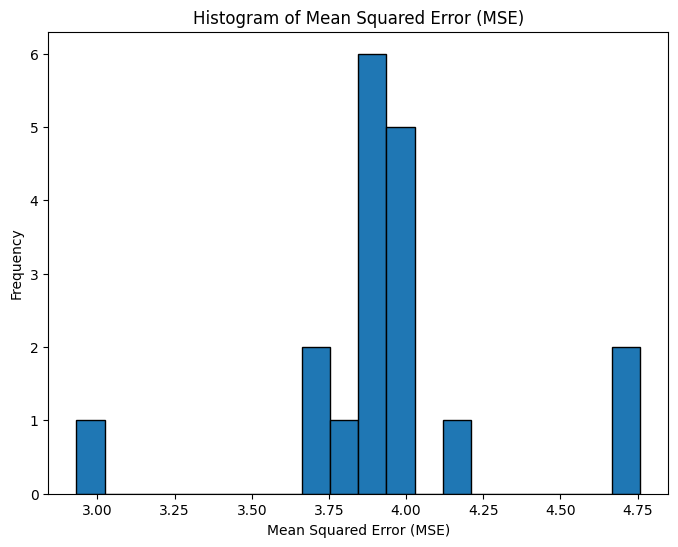

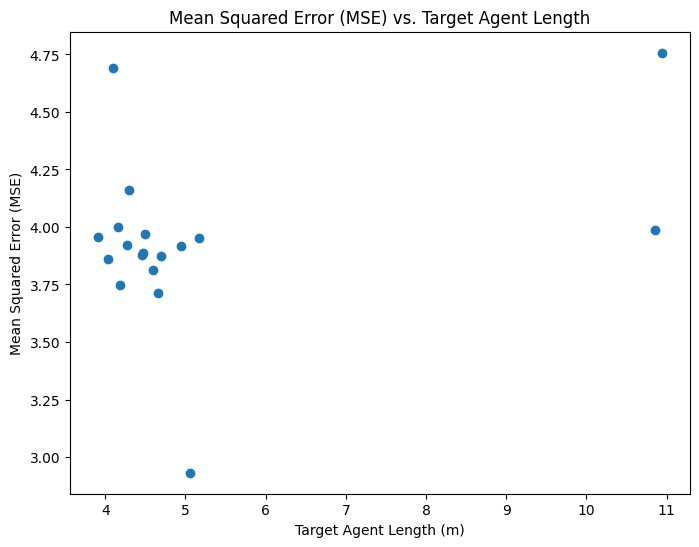

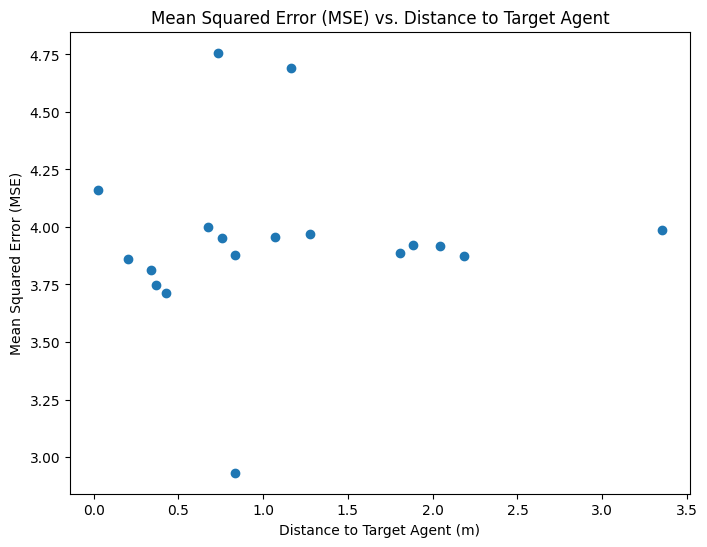

In [49]:
# Step 8: Evaluation and Visualization

def plot_trajectory_comparison(ground_truth_x, ground_truth_y, predicted_x, predicted_y, target_agent_id):
    plt.figure(figsize=(8, 6))
    plt.plot(ground_truth_x, ground_truth_y, label='Ground Truth Trajectory', color='blue')
    plt.plot(predicted_x, predicted_y, label='Predicted Trajectory', color='orange')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.title(f'Target Agent ID: {target_agent_id}')
    plt.show()

def plot_mse_histogram(mse_values):
    plt.figure(figsize=(8, 6))
    plt.hist(mse_values, bins=20, edgecolor='black')
    plt.xlabel('Mean Squared Error (MSE)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Mean Squared Error (MSE)')
    plt.show()


def plot_mse_vs_distance(mse_values, distances):
    plt.figure(figsize=(8, 6))
    plt.scatter(distances, mse_values)
    plt.xlabel('Distance to Target Agent (m)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Mean Squared Error (MSE) vs. Distance to Target Agent')
    plt.show()


def plot_mse_vs_length(mse_values, target_lengths):
    plt.figure(figsize=(8, 6))
    plt.scatter(target_lengths, mse_values)
    plt.xlabel('Target Agent Length (m)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Mean Squared Error (MSE) vs. Target Agent Length')
    plt.show()

def evaluate_trajectory_prediction(ego_agent_model, data, ego_agent_id):
    ego_agent_model, training_history = train_lstm_model(data, ego_agent_id)

    # Evaluate trajectory prediction for each target agent
    mse_values = []
    distances = []
    target_agents = data[data['track_to_predict'] == 1]['track_id'].unique()

    for target_agent_id in target_agents:
        target_agent_data = data[data['track_id'] == target_agent_id]
        target_agent_data = preprocess_data(target_agent_data)

        # Prepare input sequences for LSTM (reshaping to the correct shape)
        input_sequence_target, _ = prepare_input_sequences(target_agent_data, sequence_length)

        # Predict future trajectory for the target agent
        predicted_sequence_target = ego_agent_model.predict(input_sequence_target)

        # Calculate and print the Mean Squared Error for the target agent's trajectory prediction
        mse_target = calculate_mse(predicted_sequence_target, target_agent_data[['x', 'y']])
        mse_values.append(mse_target)

        # Calculate distance to the target agent at the last timestep
        distance = np.sqrt((target_agent_data['x'].iloc[-1] - ego_agent_data['x'].iloc[-1])**2 +
                           (target_agent_data['y'].iloc[-1] - ego_agent_data['y'].iloc[-1])**2)
        distances.append(distance)

    # Plot the MSE histogram
    plot_mse_histogram(mse_values)

    # Plot MSE vs. Target Agent Length
    target_lengths = data[data['track_to_predict'] == 1].groupby('track_id')['length'].unique()
    target_lengths = [length[0] for length in target_lengths]  # Convert array of arrays to a flat list
    plot_mse_vs_length(mse_values, target_lengths)

    # Plot MSE vs. Distance to Target Agent
    plot_mse_vs_distance(mse_values, distances)

# Call the evaluation function
evaluate_trajectory_prediction(ego_agent_model, data, ego_agent_id)

